# Fine-Tune HyenaDNA On A Downstream Classification Task

In this notebook, we will fine-tune the HynaDNA model on a downstream binary classification task involving cis-regulatory elements.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/helicalAI/helical/blob/main/examples/notebooks/HyenaDNA-Fine-Tuning.ipynb)

### Install the package

In [ ]:
# !pip install helical

# ** HyenaDNA *** 
Hyena is a genomic foundation model designed to process DNA sequences at single-nucleotide resolution over extremely long contexts—up to 1 million tokens. This represents a 500x increase in context length compared to previous Transformer-based models, which were limited to 512–4,000 tokens due to the quadratic scaling of attention mechanisms.

 Key Innovations
Single-Nucleotide Tokenization: HyenaDNA uses a vocabulary of just five tokens—A, C, G, T, and N—allowing it to model DNA sequences at the finest possible resolution without relying on k-mers or token aggregation 
Hugging Face

Hyena Operator Architecture: Instead of attention, HyenaDNA employs the Hyena operator—a convolution-based mechanism that scales sub-quadratically with sequence length. This enables efficient training and inference on long sequences 
Hugging Face

Sequence Length Warm-Up: To stabilize training on ultra-long sequences, HyenaDNA introduces a scheduling technique that gradually increases sequence length during training. This approach reduces training time by up to 40% and improves accuracy 
ar5iv

In-Context Learning: HyenaDNA demonstrates the first use of in-context learning in genomics, allowing it to adapt to new tasks without updating pretrained model weights. This is achieved through techniques like soft prompting and instruction fine-tuning 


HyenaDNA's capabilities make it suitable for a range of genomic tasks, including:​

Predicting regulatory elements

Analyzing chromatin profiles

Species classification

Identifying enhancers and promoters


### Imports

In [1]:
from helical.models.hyena_dna import HyenaDNA, HyenaDNAConfig, HyenaDNAFineTuningModel
from datasets import load_dataset
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import logging, warnings
import numpy as np

logging.getLogger().setLevel(logging.ERROR)

warnings.filterwarnings("ignore")

INFO:datasets:PyTorch version 2.6.0 available.


Make use of GPU if there is a GPU present, otherwise default to the CPU

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Dataset Download

- We now use the Hugging Face API to download the [dataset](https://huggingface.co/datasets/InstaDeepAI/nucleotide_transformer_downstream_tasks_revised)
- We select the task from the list of tasks available for this dataset

In [3]:
label = "promoter_tata"
dataset_train = load_dataset("InstaDeepAI/nucleotide_transformer_downstream_tasks_revised", label, split="train", trust_remote_code=True)
dataset_test = load_dataset("InstaDeepAI/nucleotide_transformer_downstream_tasks_revised", label, split="test", trust_remote_code=True)



Using the latest cached version of the module from /iridisfs/ddnb/Ahmed/AI_hackathon25/.cache/huggingface/modules/datasets_modules/datasets/InstaDeepAI--nucleotide_transformer_downstream_tasks_revised/c474eb6118e50391bce4ca7187ae0d9809b8cd611d21134179dba647656b3361 (last modified on Mon Apr 14 17:51:04 2025) since it couldn't be found locally at InstaDeepAI/nucleotide_transformer_downstream_tasks_revised, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from /iridisfs/ddnb/Ahmed/AI_hackathon25/.cache/huggingface/modules/datasets_modules/datasets/InstaDeepAI--nucleotide_transformer_downstream_tasks_revised/c474eb6118e50391bce4ca7187ae0d9809b8cd611d21134179dba647656b3361 (last modified on Mon Apr 14 17:51:04 2025) since it couldn't be found locally at InstaDeepAI/nucleotide_transformer_downstream_tasks_revised, or remotely on the Hugging Face Hub.


In [7]:
shuffled_dataset = dataset_train.shuffle(seed=42)  # you can set a seed for reproducibility
dataset_train = shuffled_dataset.select(range(1000))

unique, counts = np.unique(dataset_train["label"], return_counts=True)
dict(zip(unique, counts))


{0: 511, 1: 489}

In [ ]:
shuffled_dataset = dataset_test.shuffle(seed=42)  # you can set a seed for reproducibility
dataset_test = shuffled_dataset.select(range(20))

unique, counts = np.unique(dataset_test["label"], return_counts=True)
dict(zip(unique, counts))

HyenaDNA Model Configuration Options
model_name
Specifies the name or variant of the model to use. Examples include:

"hyenadna-tiny-1k-seqlen": a lightweight model for short sequences.

"hyenadna-tiny-1k-seqlen-d256": similar, but with a different embedding dimension.

batch_size
Defines how many sequences are processed together during training or inference. Affects memory usage and training speed.

n_layer
Number of layers in the model. Increasing this typically allows the model to learn more complex representations, at the cost of higher computational requirements.

vocab_size
Number of distinct tokens in the vocabulary. For DNA, this typically includes A, C, G, T, and special tokens like N or padding.

resid_dropout
Dropout rate applied to residual connections to help prevent overfitting by randomly deactivating parts of the network during training.

embed_dropout
Dropout applied to the embedding layer. Helps regularize the model and prevent overfitting.

fused_mlp
If True, enables a fused implementation of the multi-layer perceptron (MLP) block for improved performance on supported hardware.

fused_dropout_add_ln
If True, uses a fused operation that combines dropout, addition, and layer normalization into a single efficient step.

residual_in_fp32
If True, computes residual connections in 32-bit floating point precision to improve numerical stability, even if other parts of the model use mixed precision.

checkpoint_mixer
If True, enables gradient checkpointing for the mixer layers. This saves memory by recomputing intermediate activations during backpropagation.

checkpoint_mlp
If True, enables gradient checkpointing for the MLP layers. This also reduces memory usage during training.

pad_vocab_size_multiple
Pads the vocabulary size so it's a multiple of this number. This can help with hardware optimization and memory alignment.

return_hidden_state
If True, the model returns the hidden states from the final layer, which can be useful for downstream tasks or analysis.

device
Specifies whether to run the model on the CPU or GPU:

"cpu": for environments without a GPU.

"cuda": uses the GPU for faster computation.

layer
A dictionary of parameters specific to the Hyena layer. Example options include:

_name_: The name of the layer type (e.g., "hyena").

emb_dim: Embedding dimension size.

filter_order: Controls the complexity of the long convolution filter.

local_order: Controls local receptive field order.

l_max: Maximum sequence length the model can process.

modulate: Whether to use modulation (adds nonlinearity to the filter).

w: Positional encoding scaling factor.

lr: Learning rate for this layer.

wd: Weight decay (regularization).

lr_pos_emb: Learning rate for positional embeddings.

Since this is a binary classification task, only 2 labels are present below

### Define our HyenaDNA fine-tuning model and configs

In [12]:
hyena_config = HyenaDNAConfig(model_name="hyenadna-tiny-1k-seqlen-d256", batch_size=10, device=device)


hyena_fine_tune = HyenaDNAFineTuningModel(hyena_config, fine_tuning_head="classification", output_size=len(np.unique(dataset_train["label"])))



Fine-Tuning Parameters
hyena_config
Type: HyenaDNAConfig
This is the configuration object for the base HyenaDNA model. It includes all architectural and training parameters used when instantiating the original HyenaDNA model (e.g., number of layers, embedding size, sequence length, dropout rates, etc.). This config ensures consistency between pretraining and fine-tuning.

fine_tuning_head
Type: Literal["classification", "regression"] | HelicalBaseFineTuningHead
Specifies the type of task-specific head to append to the base model for fine-tuning:

"classification": Adds a classification head suitable for categorical outputs (e.g., predicting labels).

"regression": Adds a regression head for continuous-valued outputs.

Alternatively, a custom head can be provided by subclassing HelicalBaseFineTuningHead for advanced use cases.

output_size
Type: Optional[int], default = None
Defines the number of output units in the fine-tuning head:

Required if using a built-in "classification" or "regression" head.

For classification, this typically equals the number of classes.

For regression, this is usually 1 (for scalar output) or more for multi-target regression.

### Process the dataset for both training and testing

In [19]:
train_dataset = hyena_fine_tune.process_data(dataset_train["sequence"])
test_dataset = hyena_fine_tune.process_data(dataset_test["sequence"])

train_dataset



Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})

### Fine-tune the model

For this we set our training and validation datasets along with their labels

In [20]:
hyena_fine_tune.train(train_dataset=train_dataset, train_labels=dataset_train["label"], validation_dataset=test_dataset, validation_labels=dataset_test["label"], epochs=2, optimizer_params={"lr": 2e-6}, lr_scheduler_params={"name": "linear", "num_warmup_steps": 0})

Fine-Tuning Validation: 100%|█████| 2/2 [00:00<00:00, 13.28it/s, val_loss=0.696]


### Evaluate the fine-tuned model

We now get the outputs of the model on our test dataset and display some results

In [21]:
outputs = hyena_fine_tune.get_outputs(test_dataset)
outputs

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 16.13it/s]


array([[-0.4797687 ,  0.02887641],
       [-0.48232496,  0.01475056],
       [-0.50222754,  0.02098477],
       [-0.4679351 , -0.10981619],
       [-0.4359222 ,  0.03955469],
       [-0.51171106, -0.04342298],
       [-0.45593768, -0.00823345],
       [-0.45936212, -0.05231581],
       [-0.4833535 , -0.10416786],
       [-0.3941361 , -0.04740041],
       [-0.38380933, -0.02322714],
       [-0.44017655,  0.03337285],
       [-0.45276272,  0.02521587],
       [-0.4809475 , -0.03297615],
       [-0.4467274 , -0.10441881],
       [-0.30241764, -0.2126725 ],
       [-0.49282533, -0.04030855],
       [-0.42225382, -0.0349885 ],
       [-0.59223974,  0.04007456],
       [-0.4289731 , -0.08156896]], dtype=float32)

In [26]:
print(classification_report(dataset_test["label"], outputs.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.55      1.00      0.71        11

    accuracy                           0.55        20
   macro avg       0.28      0.50      0.35        20
weighted avg       0.30      0.55      0.39        20



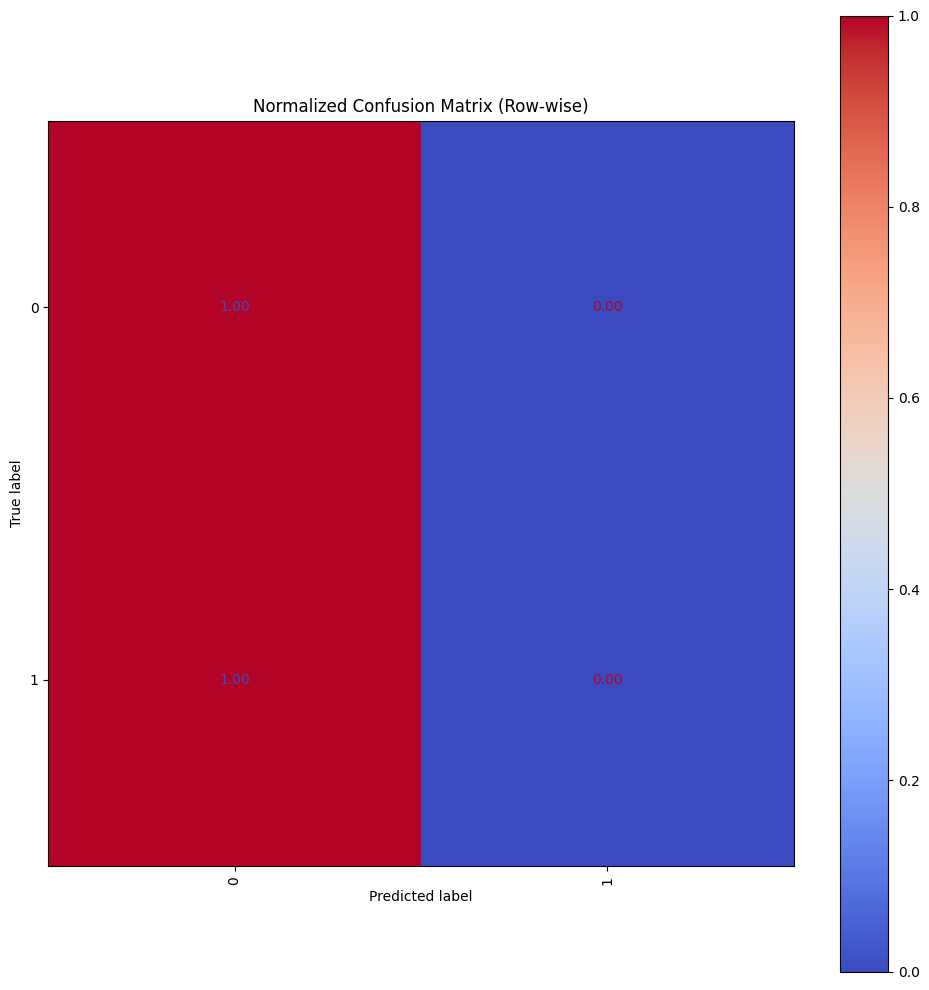

In [28]:
# Compute the confusion matrix
cm = confusion_matrix(dataset_test["label"], outputs.argmax(axis=1))

# Perform row-wise normalization
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Get unique labels in the order they appear in the confusion matrix
unique_labels = np.unique(np.concatenate((dataset_test["label"], outputs.argmax(axis=1))))

# Create and plot the normalized confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=unique_labels)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='.2f', cmap='coolwarm')

# Customize the plot
ax.set_title('Normalized Confusion Matrix (Row-wise)')
fig.set_facecolor("none")

plt.tight_layout()
plt.show()